In [5]:
import pandas as pd
import numpy as np

# Load the dataset
file_path = "C:\\Users\\ADWIN ADI\\Downloads\\breathing.csv files\\MainData_Cleaned_QIR.csv"
df = pd.read_csv(file_path)

print("Original shape:", df.shape)
print("First few rows:\n", df.head())

# Drop rows with NaN values (optional)
df.dropna(inplace=True)

# Define segmentation parameters
sampling_rate = 15             # Hz
segment_duration = 10          # seconds
samples_per_segment = sampling_rate * segment_duration

# Compute how many full segments can be formed
num_segments = len(df) // samples_per_segment
print(f"Total full segments to be created: {num_segments}")

# Trim the DataFrame to full segments only
df = df.iloc[:num_segments * samples_per_segment].copy()

# Add segment_id column
df['segment_id'] = np.repeat(np.arange(num_segments), samples_per_segment)

# Compute majority label per segment
majority_labels = (
    df.groupby('segment_id')['Label']
    .agg(lambda x: x.value_counts().idxmax())
    .reset_index()
)

# Merge the majority label back to each row in the segment
df = df.drop(columns=['Label'])  # Drop original Label
df = df.merge(majority_labels, on='segment_id')  # Add majority Label per segment

# Save the segmented data
output_path = "C:\\Users\\ADWIN ADI\\Downloads\\MainData_10sec_Segmented.csv"
df.to_csv(output_path, index=False)

print(f"Segmented dataset (row-wise) saved to: {output_path}")
print("Final shape:", df.shape)
print(df.head())


Original shape: (109971, 7)
First few rows:
    Sensor1_Temp  Sensor1_Pressure  Sensor1_Humidity  Sensor2_Temp  \
0          0.06            0.0263              0.01          0.05   
1          0.05            0.0261              0.01          0.04   
2          0.04            0.0221              0.19          0.03   
3          0.04            0.0119              0.32          0.03   
4          0.04            0.0117              0.38          0.03   

   Sensor2_Pressure  Sensor2_Humidity Label  
0            0.0338               0.0     N  
1            0.0440               0.0     N  
2            0.0562               0.0     N  
3            0.0457               0.0     N  
4            0.0344               0.0     N  
Total full segments to be created: 733
Segmented dataset (row-wise) saved to: C:\Users\ADWIN ADI\Downloads\MainData_10sec_Segmented.csv
Final shape: (109950, 8)
   Sensor1_Temp  Sensor1_Pressure  Sensor1_Humidity  Sensor2_Temp  \
0          0.06            0.0263 

In [6]:
import pandas as pd
import numpy as np

# Load the dataset
file_path = "C:\\Users\\ADWIN ADI\\Downloads\\MainData_10sec_Segmented.csv"
df = pd.read_csv(file_path)

# Show original data shape
print("Original shape:", df.shape)

# Define number of samples per segment (30 seconds worth)
samples_per_segment = 150

# Calculate the number of complete segments
n_segments = df.shape[0] // samples_per_segment
print(f"Total complete segments: {n_segments}")

# Trim dataset to only include complete segments
df_trimmed = df.iloc[:n_segments * samples_per_segment].copy()

# Assign segment IDs for grouping
df_trimmed['segment_id'] = np.repeat(np.arange(n_segments), samples_per_segment)

# Define feature columns (exclude segment_id)
feature_columns = df_trimmed.columns.difference(['segment_id'])

# Stack into 3D NumPy array: (segments, samples_per_segment, features)
X = np.stack([
    group[1][feature_columns].to_numpy()
    for group in df_trimmed.groupby('segment_id')
])

# Show shape of resulting array
print(f"Shape of X: {X.shape}") # Expected shape: (n_segments, 450, n_features)




Original shape: (109950, 8)
Total complete segments: 733
Shape of X: (733, 150, 7)


In [7]:
import pandas as pd

# Load the segmented file
df = pd.read_csv("C:\\Users\\ADWIN ADI\\Downloads\\MainData_10sec_Segmented.csv")  # or your path
print(df.columns)

Index(['Sensor1_Temp', 'Sensor1_Pressure', 'Sensor1_Humidity', 'Sensor2_Temp',
       'Sensor2_Pressure', 'Sensor2_Humidity', 'segment_id', 'Label'],
      dtype='object')


In [9]:
print(df.columns.tolist())


['Sensor1_Temp', 'Sensor1_Pressure', 'Sensor1_Humidity', 'Sensor2_Temp', 'Sensor2_Pressure', 'Sensor2_Humidity', 'segment_id', 'Label']


In [10]:
print("Total segments:", df['segment_id'].nunique())
samples_per_segment = df['segment_id'].value_counts().unique()
print("Samples per segment:", samples_per_segment)


Total segments: 733
Samples per segment: [150]


In [11]:
import pandas as pd
import numpy as np

# Load your dataset
file_path = "C:\\Users\\ADWIN ADI\\Downloads\\MainData_30sec_Segmented.csv"
df = pd.read_csv(file_path)

# Confirm label column exists
print("Label column unique values:", df['Label'].unique())

# Define number of samples per segment
samples_per_segment = 450

# Calculate number of complete segments
n_samples = df.shape[0]
n_segments = int(n_samples // samples_per_segment)  # Ensure this is an int

print(f"Total complete segments: {n_segments}")

# Trim to full segments only
df_trimmed = df.iloc[:n_segments * samples_per_segment].copy()

# Create segment IDs
df_trimmed['segment_id'] = np.repeat(np.arange(n_segments), samples_per_segment)

# Copy label column properly
df_trimmed['Label'] = df['Label'].values[:n_segments * samples_per_segment]

# Exclude non-feature columns
feature_columns = df_trimmed.columns.difference(['segment_id', 'Label'])

# Reshape into (n_segments, 450, n_features)
X = np.stack([
    group[1][feature_columns].to_numpy()
    for group in df_trimmed.groupby('segment_id')
])

# Group labels per segment using mode
y = df_trimmed.groupby('segment_id')['Label'].agg(lambda x: x.mode()[0]).to_numpy()

print(f"\nX shape: {X.shape} (segments, 450 samples, {X.shape[2]} features)")
print(f"y shape: {y.shape} (segments)")
print("Labels:", np.unique(y))

Label column unique values: ['N' 'R' 'E']
Total complete segments: 244

X shape: (244, 450, 6) (segments, 450 samples, 6 features)
y shape: (244,) (segments)
Labels: ['E' 'N' 'R']


In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Encoded y example:", y_encoded[:10])
print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))


Encoded y example: [1 1 1 1 1 1 1 1 1 1]
Label mapping: {'E': 0, 'N': 1, 'R': 2}


In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class Attention(Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)

    def call(self, inputs):
        e = tf.nn.tanh(tf.matmul(inputs, self.W) + self.b)
        a = tf.nn.softmax(e, axis=1)
        output = inputs * a
        return tf.reduce_sum(output, axis=1)


In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Add, Layer
from tensorflow.keras.models import Model

class CustomAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(CustomAttention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)
        self.b = self.add_weight(shape=(1,), initializer='zeros', trainable=True)

    def call(self, inputs):
        score = tf.nn.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * inputs
        return tf.reduce_sum(context_vector, axis=1)

def build_super_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # CNN block
    x = Conv1D(64, 3, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.3)(x)
    x = Conv1D(128, 3, activation='relu', padding='same')(x)
    x = MaxPooling1D(2)(x)

    # LSTM block
    lstm_out = LSTM(128, return_sequences=True)(x)

    # Transformer block
    norm = LayerNormalization()(lstm_out)
    mha = MultiHeadAttention(num_heads=4, key_dim=64)(norm, norm)
    add = Add()([mha, lstm_out])
    x = LayerNormalization()(add)

    # Custom Attention Layer
    attention_output = CustomAttention()(x)

    # Final dense output
    x = Dense(128, activation='relu')(attention_output)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)




In [15]:
import numpy as np

print(np.unique(y))  # Should print classes like ['Normal' 'Recovery' 'Endurance']


['E' 'N' 'R']


In [16]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # e.g., ['Normal', 'Recovery', 'Endurance'] → [0, 1, 2]

# One-hot encode
y_cat = to_categorical(y_encoded)


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y_cat)


In [26]:
model = build_super_model(X.shape[1:], num_classes=y_cat.shape[1])
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 450, 6)]     0           []                               
                                                                                                  
 conv1d_2 (Conv1D)              (None, 450, 64)      1216        ['input_2[0][0]']                
                                                                                                  
 max_pooling1d_2 (MaxPooling1D)  (None, 225, 64)     0           ['conv1d_2[0][0]']               
                                                                                                  
 dropout_2 (Dropout)            (None, 225, 64)      0           ['max_pooling1d_2[0][0]']        
                                                                                            

In [27]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)


In [28]:
# Predict on test data
y_pred_probs = model.predict(X_test)

# Convert predicted one-hot vectors to class indices
y_pred_indices = np.argmax(y_pred_probs, axis=1)

# Decode indices to original labels
y_pred_labels = le.inverse_transform(y_pred_indices)

print("Predicted labels:", y_pred_labels[:10])  # Just previewing first 10


Predicted labels: ['N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N']


In [29]:
y_true_indices = np.argmax(y_test, axis=1)
y_true_labels = le.inverse_transform(y_true_indices)

print("True labels:", y_true_labels[:10])


True labels: ['R' 'N' 'R' 'N' 'R' 'N' 'E' 'N' 'N' 'N']


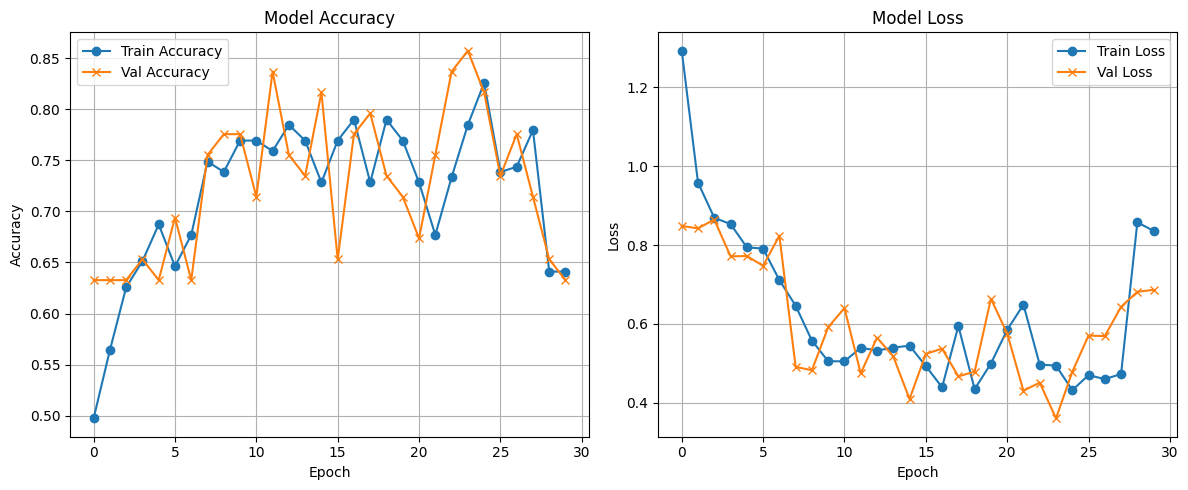

In [30]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o') # type: ignore
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='x')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='x')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [35]:
y_pred = model.predict(X_test)
y_test_cat = np.argmax(X_test, axis=1)

In [36]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np

# Convert one-hot predictions and ground truth to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_cat, axis=1)


In [231]:
y = df_trimmed.groupby('segment_id')['Label'].agg(lambda x: x.mode()[0]).to_numpy()


In [232]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Encode string labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# One-hot encode
y_cat = to_categorical(y_encoded)

# Split into train and test
X_train, X_test, y_train_cat, y_test_cat = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y_encoded)

# Print shape confirmation
print("X_train:", X_train.shape, "| y_train_cat:", y_train_cat.shape)
print("X_test:", X_test.shape, "| y_test_cat:", y_test_cat.shape)


X_train: (195, 450, 6) | y_train_cat: (195, 3)
X_test: (49, 450, 6) | y_test_cat: (49, 3)


In [37]:
y_pred = model.predict(X_test)


In [38]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np

# Convert one-hot predictions and ground truth to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_cat, axis=1)


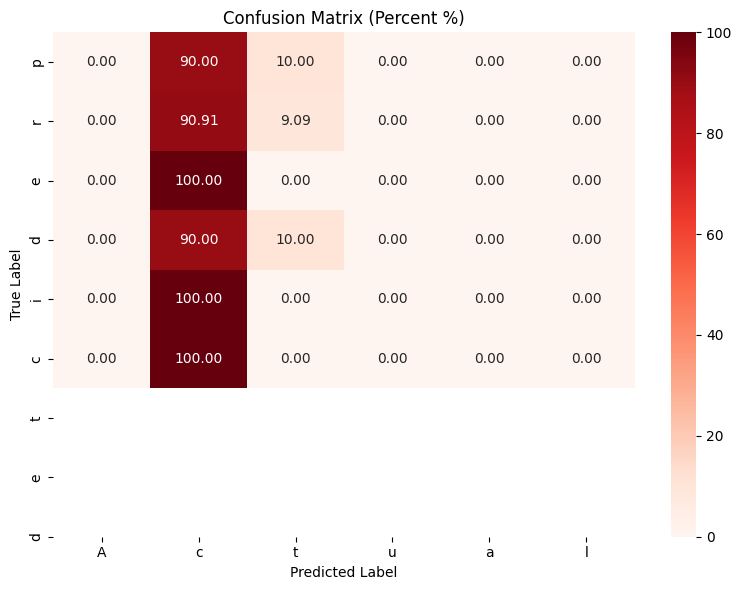

In [41]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Normalize row-wise (per true class)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Round to 2 decimal places
cm_percent = np.round(cm_percent, 2)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Reds',
            xticklabels='Actual', yticklabels='predicted')
plt.title("Confusion Matrix (Percent %)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()



In [44]:
from sklearn.metrics import classification_report

report = classification_report(y_true_classes, y_pred_classes, target_names=Labels, digits=4)
print("Classification Report:\n", report)


NameError: name 'Labels' is not defined

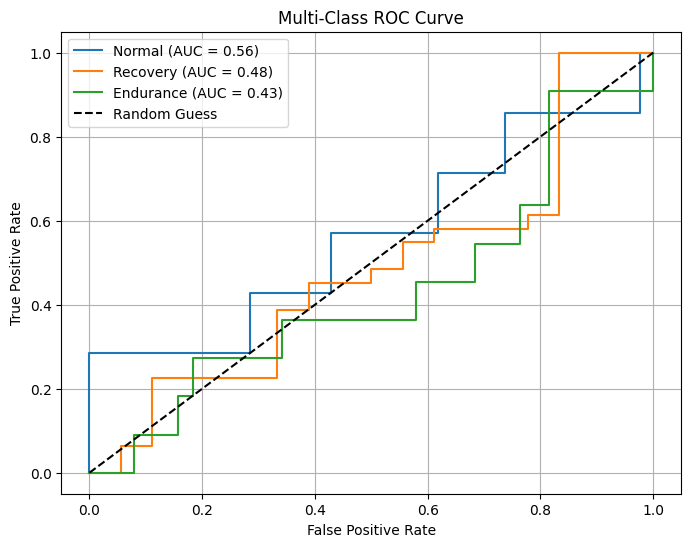

In [237]:
from sklearn.preprocessing import label_binarize

# Binarize the true labels for ROC
y_test_bin = label_binarize(y_true_classes, classes=[0, 1, 2])
y_pred_bin = y_pred  # Already softmax output

fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(8, 6))

for i in range(len(labels)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{labels[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title("Multi-Class ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


In [238]:
from sklearn.metrics import classification_report
import pandas as pd

# Already predicted classes:
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_cat, axis=1)

# Get label names back from encoder
label_names = label_encoder.classes_

# Generate classification report as dict
report_dict = classification_report(y_true_classes, y_pred_classes, target_names=label_names, output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Save to CSV
report_df.to_csv("classification_report.csv", index=True)

print("Classification report exported to 'classification_report.csv'")


Classification report exported to 'classification_report.csv'


C:\Users\ADWIN ADI\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ADWIN ADI\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ADWIN ADI\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [239]:
from sklearn.metrics import classification_report
import pandas as pd

# Compute classification report
report_dict = classification_report(y_true_classes, y_pred_classes, target_names=label_names, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Drop summary rows for now (we'll re-add them later)
class_only_df = report_df.iloc[:-3].copy()

# Find class with highest F1-score
best_f1_class = class_only_df['f1-score'].idxmax()

# Style the DataFrame to highlight the best F1-score row
def highlight_best_class(row):
    return ['background-color: lightgreen' if row.name == best_f1_class else '' for _ in row]

styled_df = report_df.style.apply(highlight_best_class, axis=1)

# Export to Excel with styling
styled_df.to_excel("classification_report_highlighted.xlsx", engine='openpyxl')

print(f" Exported with highlight: Best F1 class is '{best_f1_class}'")


 Exported with highlight: Best F1 class is 'N'


C:\Users\ADWIN ADI\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ADWIN ADI\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ADWIN ADI\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av